# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. This code is already included in 'tensorflow_vgg' directory, sdo you don't have to clone it.

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# フォルダが無かったら、エラーを出力する
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

# tqdmクラスを継承して、ダウンロード進捗・表示用クラスを作成    
class DLProgress(tqdm):
    # メンバの初期化
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        # ここでは不使用
        self.total = total_size
        # tqdmの update 関数。 引数はインクリメント。
        # 　ここの引数は、常に1 -> つまり、毎回1個、ブロックが増える
        self.update((block_num - self.last_block) * block_size)
        # 
        self.last_block = block_num

In [2]:
# ダウンロード開始        
# vgg16.npy　が無かったら、with以下を実行する
if not isfile(vgg_dir + "vgg16.npy"):
    # pbar というインスタンス作成（初期化）、引数は、tqdm.__init__()の引数と同じ
    # unit       = 表示単位 biteのB
    # unit_scale = 
    # miniters   = Minimum progress display update interval
    # desc       = 表示タイトル
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        # urlretrieve(目的のURL, 保存先のファイル名)
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook) # <----- ここで、tqdmのインスタンスを指定
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [3]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

## 以下では、下記を実施する予定
- VGGのモデルを作成し、訓練済みのデータを読み込む -> vgg.build()
- 今回使いたいデータを、そのモデルに対し予測のみ行い、下層にある最初の全結合層の出力を取得する
- 上記の出力は、のちの転移学習における入力として用いるので、出力をファイルに保存する。

## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [4]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [5]:
data_dir = 'flower_photos/'

# まず、data_dir の フォルダ と ファイル をすべて取得
contents = os.listdir(data_dir)

#　次に、フォルダのみを取得し classes　に入力
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [6]:
print("contents = ", contents)
print("classes  = ", classes )

contents =  ['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']
classes  =  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Below I'm running images through the VGG network in batches.

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

In [7]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 100
codes_list = []
labels     = []
batch      = []
codes      = None

# セッション開始
with tf.Session() as sess:
    #----------------------------------------------------------------------#
    # TODO: Build the vgg network here
    vgg    = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224,224,3])
    
    # 名前空間を指定する
    with tf.name_scope("content_vgg"):
        # モデルに訓練済みの重みをセットする.詳細は以下に書いてある
        # ./tensorflow_vgg/vgg16.py
        # self.data_dict に データを代入し、下方に記載している
        # get_conv_filter　等で、それぞれの層に代入している
        vgg.build(input_)    
        
    #----------------------------------------------------------------------#
    # 以下で、今回使いたいデータを入力し、FCの1番目の出力(vgg.relu6)を得る
    # -->> sess.run( vgg.relu6, feed_dict=feed_dict)
    # classes は、データが入ったフォルダ名
    for each in classes:
        print("Starting {} images".format(each))
        # フォルダパスの取得
        class_path = data_dir + each
        # ファイルパスの取得
        files = os.listdir(class_path)
        # ファイルをバッチ数分、メモリにロードする
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)

            # バッチ数分のロードが終わったら、下記を実行する
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                # List の batch を、connatenate　で　np.array に変更
                # len( batch )   =  10
                # batch[0].shape =  (1, 224, 224, 3)
                # images.shape   =  (10, 224, 224, 3)
                images = np.concatenate(batch)

                # TODO: Get the values from the relu6 layer of the VGG network
                feed_dict   = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    # ループ1回目の処理
                    codes = codes_batch
                else:
                    # ループ2回目以降の処理, デフォルトは axis=0
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

D:\002_Work\UdaCity\02_Deep_Learning\03_Convolutional_Networks\Jupyter\Lesson_6\02_Transfer_Learning_with_TensorFlow\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 4s
Starting daisy images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
633 images processed
Starting dandelion images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
898 images processed
Starting roses images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
641 images processed
Starting sunflowers images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
699 images processed
Starting tulips images
100 images processed
200 images processed
300 i

### 上のcellでエラーが出たので、numpyのバージョンを変更した
- 変更前　：　1.16.4
- 変更後　：　1.16.1

In [8]:
print(np.__version__)

1.16.1


In [9]:
print("vgg.relu7 = ", vgg.relu7)

vgg.relu7 =  Tensor("content_vgg/Relu_1:0", shape=(?, 4096), dtype=float32)


In [10]:
# numpy の メソッド を使ってファイルに出力（バイナリ）
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

### 先ほど作成したファイルを読み込む
- VGG16 を　通過したデータ
- 転移学習の入力用

In [11]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [12]:
print("codes.shape = ",  codes.shape)

codes.shape =  (3670, 4096)


In [13]:
print("len( labels )       = ", len( labels ))
print("np.unique( labels ) = ", np.unique( labels ))

len( labels )       =  3670
np.unique( labels ) =  ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


### LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)[source]

In [14]:
# Your one-hot encoded labels array here
from sklearn.preprocessing import LabelBinarizer

# インスタンスの作成
lb = LabelBinarizer()

# 変換の適用
labels_vecs = lb.fit_transform(labels)

# 出力の確認
#  5 class あるので、5列に0,1が記載されている
print("labels_vecs.shape = ", labels_vecs.shape)
print("labels_vecs = \n", labels_vecs)

labels_vecs.shape =  (3670, 5)
labels_vecs = 
 [[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

### sklearn　の　バージョンを変更した
- もともと入っていた sklearn　のバージョンは、　0.17
- その場合、from sklearn.cross_validation import StratifiedShuffleSplit　となる
- また、使用方法も結構異なる
- 
- そこで、バージョンを0.21.3に変更することにした
- その場合、from sklearn.model_selection import StratifiedShuffleSplit　となる
- 
- pip install -U scikit-learn

In [15]:
import sklearn
print(sklearn.__version__)

0.21.3


### StratifiedShuffleSplit(n_splits=10, test_size=None, train_size=None, random_state=None)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit　で　generator　を作成する.
# generator は pythonの一般機能
# n_split = N が generate　できる回数を指す. nextで出力を得ることが出来る
# train　と　test　の　Index　を取得し、
# test　の　index　を2分割して、　valid　と　test　の　index　を得る
ss         = StratifiedShuffleSplit(n_splits= 1, test_size = 0.2)
ss_spliter = ss.split( codes, labels_vecs )
#
train_indices, test_valid_indices = next(ss_spliter)

# この方法でもよい
# train_indices, test_indices = next(ss.split( codes, labels_vecs ))

# 結果の確認
print("train_indices.shape = ", train_indices.shape)
print("test_indices.shape  = ", test_valid_indices.shape)

train_indices.shape =  (2936,)
test_indices.shape  =  (734,)


In [17]:
# indicesの分割
num_half = int( test_valid_indices.shape[0]/2 )
valid_indices = test_valid_indices[ : num_half]
test_indices  = test_valid_indices[num_half : ]

#
print("valid_indices.shape = ", valid_indices.shape)
print("test_indices.shape  = ", test_indices.shape)

valid_indices.shape =  (367,)
test_indices.shape  =  (367,)


In [18]:
# データ分割
train_x, train_y = codes[train_indices], labels_vecs[train_indices]
val_x,     val_y = codes[valid_indices], labels_vecs[valid_indices]
test_x,   test_y = codes[test_indices],  labels_vecs[test_indices]

In [19]:
print("Train shapes (x, y)     :", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape  , val_y.shape)
print("Test shapes (x, y)      :", test_x.shape , test_y.shape)

Train shapes (x, y)     : (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y)      : (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [20]:
# 確認
print("codes.shape       = ", codes.shape)
print("labels_vecs.shape = ", labels_vecs.shape)

codes.shape       =  (3670, 4096)
labels_vecs.shape =  (3670, 5)


In [21]:
# vgg　の　FC　の出力サイズを示す
print("vgg.relu7 = ", vgg.relu7)

vgg.relu7 =  Tensor("content_vgg/Relu_1:0", shape=(?, 4096), dtype=float32)


### 注意 !!!
- tf.contrib.layers.fully_connected　の　activationのデフォルトは ReLu

In [23]:
# 変数の準備
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64,   shape=[None, labels_vecs.shape[1]])

# TODO: Classifier layers and operations
fc            = tf.contrib.layers.fully_connected(inputs_, 256                 , activation_fn=tf.nn.relu)
logits        = tf.contrib.layers.fully_connected(fc,      labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost          = tf.reduce_mean(cross_entropy)
optimizer     = tf.train.AdamOptimizer().minimize(cost)

# Operations for validation/test accuracy
predicted    = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy     = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

### x と y　から　n_batches　の　数だけデータを取る generator

In [24]:
def get_batches(x, y, n_batches=100):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [26]:
# TODO: Your training code here
epochs     = 10
batch_size = 10
counter    = 0
saver      = tf.train.Saver()
#
with tf.Session() as sess:
    # 重みの初期化
    sess.run(tf.global_variables_initializer())

    # epoch ごとのループ
    for e in range(epochs):
        # バッチ　ごとのループ
        for x, y in get_batches(train_x, train_y, n_batches=batch_size):
            # 変数の代入
            feed    = {inputs_ : x, labels_: y}
            # cost　と　optimizer　について計算を実行
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            #
            counter += 1

            # validation結果を示す
            if counter % 5 == 0:
                train_acc = sess.run(accuracy, feed_dict={inputs_:x, labels_:y})
                val_acc   = sess.run(accuracy, feed_dict={inputs_:val_x, labels_:val_y})
                #
                print("Epoch={}/{}, Iteration={}, Train_Acc={:.3f}, Val_Acc={:.3f}".format(e+1, epochs, counter, train_acc, val_acc))

    # 終了後にcheckpointを保存
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch=1/10, Iteration=5, Train_Acc=0.666, Val_Acc=0.627
Epoch=1/10, Iteration=10, Train_Acc=0.793, Val_Acc=0.796
Epoch=2/10, Iteration=15, Train_Acc=0.846, Val_Acc=0.839
Epoch=2/10, Iteration=20, Train_Acc=0.829, Val_Acc=0.804
Epoch=3/10, Iteration=25, Train_Acc=0.915, Val_Acc=0.826
Epoch=3/10, Iteration=30, Train_Acc=0.870, Val_Acc=0.856
Epoch=4/10, Iteration=35, Train_Acc=0.942, Val_Acc=0.858
Epoch=4/10, Iteration=40, Train_Acc=0.926, Val_Acc=0.853
Epoch=5/10, Iteration=45, Train_Acc=0.976, Val_Acc=0.861
Epoch=5/10, Iteration=50, Train_Acc=0.943, Val_Acc=0.866
Epoch=6/10, Iteration=55, Train_Acc=0.973, Val_Acc=0.861
Epoch=6/10, Iteration=60, Train_Acc=0.960, Val_Acc=0.866
Epoch=7/10, Iteration=65, Train_Acc=0.993, Val_Acc=0.877
Epoch=7/10, Iteration=70, Train_Acc=0.983, Val_Acc=0.875
Epoch=8/10, Iteration=75, Train_Acc=0.997, Val_Acc=0.877
Epoch=8/10, Iteration=80, Train_Acc=0.990, Val_Acc=0.875
Epoch=9/10, Iteration=85, Train_Acc=1.000, Val_Acc=0.880
Epoch=9/10, Iteration=90, Train_

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [27]:
with tf.Session() as sess:
    #　先ほど保存した checkpoint を　復元する
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # 変数の代入
    feed = {inputs_: test_x,　labels_: test_y}
    # accuracy の計算
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\flowers.ckpt
Test accuracy: 0.8992


In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

C:\Users\mbd_p\Anaconda3\envs\UdaCity_01_Intro_ML\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


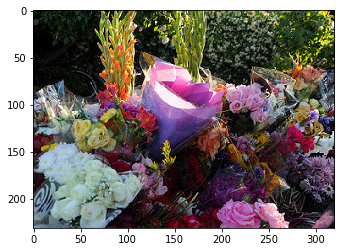

In [29]:
# テスト用画像の表示
test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [30]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [31]:
# テスト用画像で、転移学習の入力　を作成する
with tf.Session() as sess:
    img       = utils.load_image(test_img_path)
    img       = img.reshape((1, 224, 224, 3))
    feed_dict = {input_: img}
    code      = sess.run(vgg.relu6, feed_dict=feed_dict)
        
# 転移学習の入力　で　予測する
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    feed       = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints\flowers.ckpt


In [37]:
print("prediction = ", np.round(prediction,4))

prediction =  [0.000e+00 0.000e+00 9.999e-01 0.000e+00 1.000e-04]


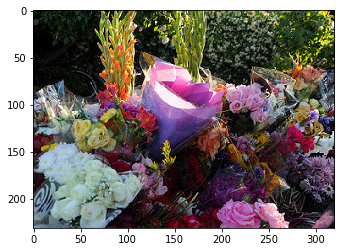

In [32]:
plt.imshow(test_img)

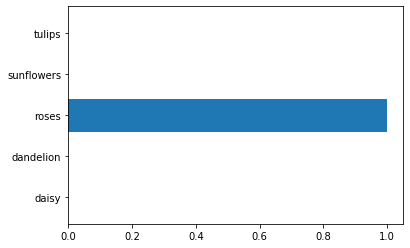

In [33]:
# 予測値　の　棒グラフ　を描画
plt.barh(np.arange(5), prediction)

# Y軸　に　クラス名を表示
_ = plt.yticks(np.arange(5), lb.classes_)